In [67]:
import gdown

file_id = '1Y2cTYR_t_10NAbznspE5bBjuATPdTgtq'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'file.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Y2cTYR_t_10NAbznspE5bBjuATPdTgtq
From (redirected): https://drive.google.com/uc?id=1Y2cTYR_t_10NAbznspE5bBjuATPdTgtq&confirm=t&uuid=16fccd89-c6e6-4dac-ba65-2d9f5a092b7f
To: /content/file.zip
100%|██████████| 134M/134M [00:01<00:00, 133MB/s]


'file.zip'

In [68]:
import zipfile

with zipfile.ZipFile('file.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [76]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt

data_dir = 'data/AISContest_Data'

data = []
labels = []

for class_label in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_label)

    if os.path.isdir(class_folder):
        class_count = 0

        for file_name in os.listdir(class_folder):
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_folder, file_name)
                class_data = np.load(file_path)

                data.append(class_data)
                labels.append(class_label)

                class_count += 1

        print(f'Loaded {class_count} samples from class: {class_label}')

data = np.array(data, dtype=np.float64)
labels = np.array(labels, dtype=np.int64)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

class_counts = Counter(encoded_labels)
print("Original class distribution:", class_counts)

Loaded 497 samples from class: 3
Loaded 418 samples from class: 4
Loaded 237 samples from class: 1
Loaded 1755 samples from class: 2
Loaded 2906 samples from class: 0
Original class distribution: Counter({0: 2906, 2: 1755, 3: 497, 4: 418, 1: 237})


In [70]:
balanced_data = []
balanced_labels = []

target_samples = 1000

for class_label in np.unique(encoded_labels):
    class_indices = np.where(encoded_labels == class_label)[0]

    num_samples = len(class_indices)

    if num_samples > target_samples:
        selected_indices = np.random.choice(class_indices, target_samples, replace=False)
    else:
        selected_indices = np.random.choice(class_indices, target_samples, replace=True)

    balanced_data.append(data[selected_indices])
    balanced_labels.append(encoded_labels[selected_indices])

balanced_data = np.concatenate(balanced_data)
balanced_labels = np.concatenate(balanced_labels)

new_class_counts = Counter(balanced_labels)
print(new_class_counts)


Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000})


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


test_size = 0.23
val_size = 0.25

x_train, x_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, test_size=test_size, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=val_size / (1 - test_size), random_state=42)

num_samples, height, width, _ = x_train.shape
x_train_reshaped = x_train.reshape(num_samples, height * width)
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train_reshaped)

x_val_reshaped = x_val.reshape(x_val.shape[0], height * width)
x_val_normalized = scaler.transform(x_val_reshaped)

x_test_reshaped = x_test.reshape(x_test.shape[0], height * width)
x_test_normalized = scaler.transform(x_test_reshaped)

x_train_normalized = x_train_normalized.reshape(x_train.shape)
x_val_normalized = x_val_normalized.reshape(x_val.shape)
x_test_normalized = x_test_normalized.reshape(x_test.shape)

print(f'Training set size: {x_train_normalized.shape}')
print(f'Validation set size: {x_val_normalized.shape}')
print(f'Test set size: {x_test_normalized.shape}')

Training set size: (3850, 51, 59, 1)
Validation set size: (374, 51, 59, 1)
Test set size: (776, 51, 59, 1)


In [72]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (51, 59, 1)

inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, kernel_size=3, kernel_initializer='glorot_uniform')(inputs)
x = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(set(labels)), activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 51, 59, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 49, 57, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 49, 57, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 750,245 (2.86 MB)

 Trainable params: 750,245 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

import tensorflow as tf
tf.keras.backend.clear_session()

In [74]:

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=len(set(labels)))
y_val = to_categorical(y_val, num_classes=len(set(labels)))

history = model.fit(x_train_normalized, y_train,
                    validation_data=(x_val_normalized, y_val),
                    epochs=25,
                    batch_size=16)

Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2109 - loss: 1.6284 - val_accuracy: 0.2460 - val_loss: 1.5923
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2258 - loss: 1.6111 - val_accuracy: 0.2914 - val_loss: 1.5886
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2632 - loss: 1.5989 - val_accuracy: 0.2326 - val_loss: 1.6632
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2941 - loss: 1.5509 - val_accuracy: 0.3503 - val_loss: 1.4685
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3819 - loss: 1.4251 - val_accuracy: 0.4037 - val_loss: 1.3407
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4982 - loss: 1.2112 - val_accuracy: 0.4599 - val_loss: 1.2780
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5392 - loss: 1.1089 - val_accuracy: 0.5053 - val_loss: 1.1624
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6082 - loss: 0.9725 - val_accuracy: 0

In [75]:
from sklearn.metrics import f1_score


y_pred = model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

f1_micro = f1_score(y_test, y_pred_classes, average='micro')
print(f'F1 Micro Score: {f1_micro:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
F1 Micro Score: 0.6598


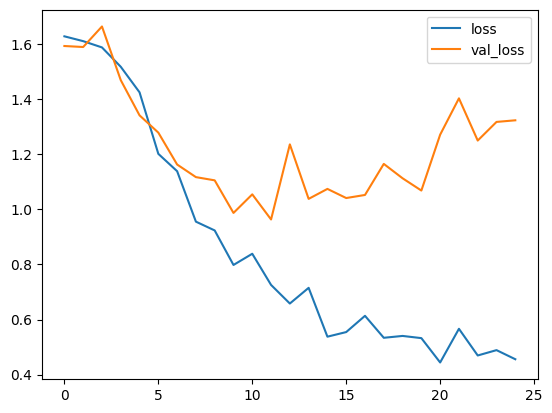

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

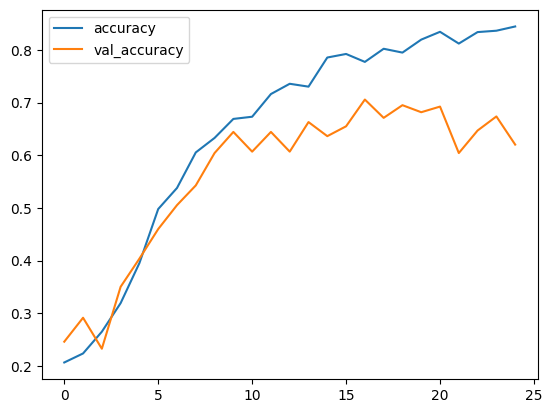

In [78]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()